# About

BERT implementation

You might want to add a CUDA device to the server

https://www.infoworld.com/article/3299703/what-is-cuda-parallel-programming-for-gpus.html

https://cloud.google.com/compute/docs/gpus/

https://cloud.google.com/compute/docs/gpus/add-gpus

https://cloud.google.com/products/calculator/

# loads our wrapper classes

we're not using NYTimes article feed
instead of the News Title vs News Body, we have Question Title vs Question Body

and we're going to make it based on Yuqing's framework, so it will be easier for Chi to adapt

In [194]:
class Suggester_BertTopicSimiliarty():
    def __init__(
        self
        , question_file
        , answer_file
        , sample_n
        , random_state
        , bert_cache
        , logger
        , device
        , max_seq_length
        , batch_size
    ):
        # initializes some vars
        self.question_file = question_file
        self.answer_file = answer_file
        self.sample_n = sample_n
        self.random_state = random_state
        self.bert_cache = bert_cache
        self.logger = logger
        self.device = device
        self.max_seq_length = max_seq_length
        self.batch_size = batch_size
        
        # gets the pre-trained tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(
            "bert-base-uncased"
            , do_lower_case = True
            , cache_dir = self.bert_cache
        )
        
        # gets the pre-trained model
        self.model = BertForNextSentencePrediction.from_pretrained(
            "bert-base-uncased"
            , cache_dir = self.bert_cache
        ).to(self.device)
        
        # instantiates the helper class
        self.ceshiner = Ceshiner()
    
    
    def _construct_corpus(self, questions, answers):
        '''
        helper function that constructs corpus
        with question id, title, accepted answer id, answer body
        note, implicitly only questions with accepted answers will end up in corpus
        '''
        t1 = questions[[
            "id"
            , "title"
            , "tags"
            , "accepted_answer_id"
        ]].rename(columns = {
            "id" : "q_id"
            , "title" : "q_title"
        })

        t2 = answers[[
            "id"
            , "body"
            , "images_list"
            , "code_snippets"
            , "cleaned_body"
        ]].rename(columns = {
            "id" : "a_id"
            , "body" : "a_body"
            , "images_list" : "a_images_list"
            , "code_snippets" : "a_code_snippets"
            , "cleaned_body" : "a_cleaned_body"
        })

        t3 = t1.merge(
            t2
            , left_on = "accepted_answer_id"
            , right_on = "a_id"
            , how = "inner"
        ).drop(columns = "a_id")
        
        # ... removes any cleaned answers that are null
        t4 = t3[t3.a_cleaned_body.notnull()]

        if self.sample_n is not None:
            t5 = t4.sample(self.sample_n, random_state = self.random_state)
        else:
            t5 = t4

        return(t5)
    
    
    def prepare(self):
        '''
        loads data & makes corpus
        '''
        self.questions = pd.read_csv(self.question_file, delimiter = "\t", encoding = "utf-8")
        self.answers = pd.read_csv(self.answer_file, delimiter = "\t", encoding = "utf-8")
        self.corpus = self._construct_corpus(self.questions, self.answers)
        print(self.corpus.shape)
    
    def get_similar_documents(self, query, num_results = 5, threshold = 0.10):
        sentence_pairs = self.ceshiner.convert_sentence_pair(
            [query] * self.corpus.shape[0]
            , self.corpus.a_cleaned_body.tolist()
            , max_seq_length = self.max_seq_length
            , tokenizer = self.tokenizer
        )
        similarity_scores = self.ceshiner.eval_pairs(
            sentence_pairs = sentence_pairs
            , batch_size = self.batch_size
            , model = self.model
        )
        self.corpus_res = self.corpus.copy()
        self.corpus_res["similarity"] = similarity_scores
        self.best_matches = self.corpus_res.copy()
        self.best_matches = self.best_matches[self.best_matches['similarity'] >= threshold]
        self.best_matches = self.best_matches.sort_values('similarity', ascending = False)
        self.best_matches = self.best_matches[:num_results]
#         res = np.argsort(self.similarity_scores)[::-1][:num_results]
#         self.best_matches = self.corpus.iloc[res]
        similar_que = self.best_matches["q_title"]
        similar_ans = self.best_matches["a_cleaned_body"]
        return(similar_que, similar_ans)


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target
        
        
class Ceshiner():
    def __init__(self):
        pass
    
    def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()
                
    def convert_sentence_pair(self, titles, descs, max_seq_length, tokenizer):
        features = []
        for (ex_index, (title, desc)) in enumerate(zip(titles, descs)):
            tokens_a = tokenizer.tokenize(title)
            
            tokens_b = None
            tokens_b = tokenizer.tokenize(desc)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

            # The convention in BERT is:
            # (a) For sequence pairs:
            #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
            #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
            # (b) For single sequences:
            #  tokens:   [CLS] the dog is hairy . [SEP]
            #  type_ids: 0   0   0   0  0     0 0
            #
            # Where "type_ids" are used to indicate whether this is the first
            # sequence or the second sequence. The embedding vectors for `type=0` and
            # `type=1` were learned during pre-training and are added to the wordpiece
            # embedding vector (and position vector). This is not *strictly* necessary
            # since the [SEP] token unambigiously separates the sequences, but it makes
            # it easier for the model to learn the concept of sequences.
            #
            # For classification tasks, the first vector (corresponding to [CLS]) is
            # used as as the "sentence vector". Note that this only makes sense because
            # the entire model is fine-tuned.
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
            segment_ids = [0] * len(tokens)

            if tokens_b:
                tokens += tokens_b + ["[SEP]"]
                segment_ids += [1] * (len(tokens_b) + 1)

            input_ids = tokenizer.convert_tokens_to_ids(tokens)

            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1] * len(input_ids)

            # Zero-pad up to the sequence length.
            padding = [0] * (max_seq_length - len(input_ids))
            input_ids += padding
            input_mask += padding
            segment_ids += padding

            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length

            if ex_index < 5:
                logger.info("*** Example ***")
                logger.info("tokens: %s" % " ".join(
                        [str(x) for x in tokens]))
                logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
                logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
                logger.info(
                        "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

            features.append(
                    InputFeatures(
                        input_ids=input_ids,
                        input_mask=input_mask,
                        segment_ids=segment_ids,
                        target=1
            ))
        return features
    
    def eval_pairs(self, sentence_pairs, batch_size, model):
        logger.info("***** Running evaluation *****")
        all_input_ids = torch.tensor([f.input_ids for f in sentence_pairs], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in sentence_pairs], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in sentence_pairs], dtype=torch.long)
        eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
        # Run prediction for full data
        eval_sampler = SequentialSampler(eval_data)
        eval_dataloader = DataLoader(eval_data, sampler = eval_sampler, batch_size = batch_size)

        logger.info("  Num examples = %d", len(sentence_pairs))
        logger.info("  Batch size = %d", batch_size)

        model.eval()

        res = []

        mb = progress_bar(eval_dataloader)
        for input_ids, input_mask, segment_ids in mb:
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)

            with torch.no_grad():
                res.append(nn.functional.softmax(
                    model(input_ids, segment_ids, input_mask), dim=1
                )[:, 0].detach().cpu().numpy())

        res = np.concatenate(res)
        return(res)

In [195]:
# i.e. app.py

import gcsfs
import os
import logging
import random
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import gc
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.modeling import BertForNextSentencePrediction
from pytorch_pretrained_bert.tokenization import BertTokenizer
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import StratifiedShuffleSplit


# defines seed for replication
SEED = 20191114

# defines cache folder for BERT model
PYTORCH_PRETRAINED_BERT_CACHE = "../models/bert/"

SAMPLE_SIZE = 10
BATCH_SIZE = 128
MAX_SEQ_LENGTH = 200

# creates a logger
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("bert")


# detects the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# sets random states
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)


# this uses gcsfs library
# fs = gcsfs.GCSFileSystem(project='w210-jcgy-254100')
# p_base_dir = "w210-jcgy-bucket/w210-data-output-new-q-and-a-files-with-separate-cleaned-answer-bodies"
# p_questions = os.path.join(p_base_dir, "PostQuestionsFiltered_V4_parsed.tsv")
# p_answers = os.path.join(p_base_dir, "PostAnswersFiltered_V4_cleaned_answer_bodies.tsv")
# with fs.open(p_questions, 'rb') as f_q:
#     with fs.open(p_answers, 'rb') as f_a:
#         m = tfModel_BertTopicSimiliarty(f_q, f_a)

# this relies on bucket being mounted, might be a bit faster to load the files
p_base_dir = "/mnt/disks/w210-jcgy-bucket/w210-data-output-new-q-and-a-files-with-separate-cleaned-answer-bodies"
p_questions = os.path.join(p_base_dir, "PostQuestionsFiltered_V4_parsed.tsv")
p_answers = os.path.join(p_base_dir, "PostAnswersFiltered_V4_cleaned_answer_bodies.tsv")
m = Suggester_BertTopicSimiliarty(
    p_questions
    , p_answers
    , sample_n = SAMPLE_SIZE
    , random_state = SEED
    , bert_cache = PYTORCH_PRETRAINED_BERT_CACHE
    , logger = logger
    , device = device
    , max_seq_length = MAX_SEQ_LENGTH
    , batch_size = BATCH_SIZE
)

11/15/2019 09:52:27 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at ../models/bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
11/15/2019 09:52:28 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ../models/bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
11/15/2019 09:52:28 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file ../models/bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpq894dvh5
11/15/2019 09:52:32 - INFO - pytorch_pretrained_bert.modeling -   Model config {

In [196]:
# loads data and builds a corpus
m.prepare()

(10, 8)


In [ ]:
# gets similar queries
similar_que, similar_ans = m.get_similar_documents(query = "this is a query", num_results = 2)

# checks

In [ ]:
sentence_pairs = m.ceshiner.convert_sentence_pair(
    titles = m.corpus.q_title.tolist()
    , descs = m.corpus.a_cleaned_body.tolist()
    , max_seq_length = 200
    , tokenizer = m.tokenizer
)

In [ ]:
sentence_pairs_2 = m.ceshiner.convert_sentence_pair(
    titles = ["this is a query"] * m.corpus.shape[0]
    , descs = m.corpus.a_cleaned_body.tolist()
    , max_seq_length = 200
    , tokenizer = m.tokenizer
)

In [203]:
print(similar_que)

123768       Invert image displayed by imshow in matplotlib
47204     How to perform undirected graph processing fro...
Name: q_title, dtype: object


In [204]:
print(similar_ans)

123768     Specify the keyword argument or in your call ...
47204      Ok, here's my stab at the problem. Here's a s...
Name: a_cleaned_body, dtype: object


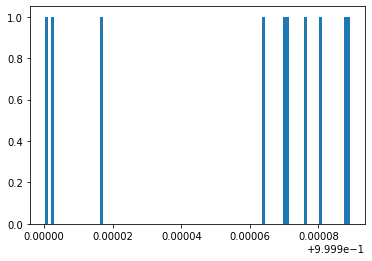

In [205]:
_ = plt.hist(m.corpus_res.similarity, bins = 100)

In [206]:
t1 = m.corpus_res.similarity
sum(t1 > 0.99) / len(t1), sum(t1 > 0.9) / len(t1), sum(t1 < 0.5) / len(t1)

(1.0, 1.0, 0.0)

In [207]:
m.best_matches.shape

(2, 9)

In [208]:
m.best_matches.head(3)

,q_id,q_title,tags,accepted_answer_id,a_body,a_images_list,a_code_snippets,a_cleaned_body,similarity
123768,8396101,Invert image displayed by imshow in matplotlib,pythonimagematplotlib,8396124.0,<p>Specify the keyword argument <code>origin='...,[],"[<code>origin='lower'</code>, <code>origin='up...",Specify the keyword argument or in your call ...,0.999989
47204,2807151,How to perform undirected graph processing fro...,sqlgraphactivemq,2807579.0,"<p>Ok, here's my stab at the problem. </p>\r\r...",[],[<code>[nodes]\r\r\nnode : varchar(xx)\r\r\n\r...,"Ok, here's my stab at the problem. Here's a s...",0.999988


# list of user input questions

note, if running on just CPU, is way too slow even with only 600 records

In [ ]:
question_list = [
    'Is there a way to visualize the distribution of my data?'
#     'How do I show data on a map?',
#     'How can I illustrate changes in my data over time?',
#     'Is there a way to show a “heatmap” of my data?',
#     'How can I present a picture of a network?',
#     'How can I plot a comparison of two data sets?',
#     'How can I create a chart without coding?',
#     'When should I use a bar chart versus a pie chart?',
#     'What is the easiest way to create a diagram of a network?',
#     'I need help creating a visualization/diagram/presentation of my data',
#     'When should I use a scatter plot?',
#     'Data visualization tips',
#     'How do I make a network diagram in d3?',
#     'How do I plot 2 datasets?',
#     'How can I animate a bar chart in Python?',
#     'I know how to create a line chart with matplotlib, but how do I do it in R?',
#     'What is the easiest way to create a heat map of the US?',
#     'How can I animate a choropleth in Tableau?  In PowerBI?  In D3?'
]

def g1(question_list, m):
    res = []
    res_df = pd.DataFrame()
    for q in question_list:
        similar_que, similar_ans = m.get_similar_documents(query = q, num_results = 5)
        t1 = m.best_matches.copy()
        t1["user_input"] = q
        t2 = t1[[
            "user_input"
            , "similarity"
            , "q_id"
            , "q_title"
            , "tags"
            , "accepted_answer_id"
            , "a_body"
            , "a_cleaned_body"
        ]]
        res.append(t2)
    res_df = pd.concat(res)
    res_df.sort_values(["user_input", "similarity"], ascending=[True, False])
    return(res_df)

t1 = g1(question_list,m)

In [211]:
t1

,user_input,similarity,q_id,q_title,tags,accepted_answer_id,a_body,a_cleaned_body
47204,Is there a way to visualize the distribution o...,0.999989,2807151,How to perform undirected graph processing fro...,sqlgraphactivemq,2807579.0,"<p>Ok, here's my stab at the problem. </p>\r\r...","Ok, here's my stab at the problem. Here's a s..."
19203,Is there a way to visualize the distribution o...,0.999981,53022319,How to get statistics from a histogram?,python-3.xnumpymatplotlib,53022701.0,"<p>Based on my answer <a href=""https://stackov...",Based on my answer here skewness and kurtosis...
78853,Is there a way to visualize the distribution o...,0.999978,19554822,Xcode command line tool - how to run in terminal?,xcodecommand-line,19554870.0,"<p>Assuming your executable is named ""my_progr...","Assuming your executable is named ""my_program..."
141013,Is there a way to visualize the distribution o...,0.999973,35909614,Plot Impulse Response Function (new),rplot,35912971.0,<p>Assuming you have your <code>irf</code> obj...,Assuming you have your object in you can firs...
176973,Is there a way to visualize the distribution o...,0.999961,48912963,Powershell script running in vsts release not ...,powershellenvironment-variablesazure-devopsazu...,48913456.0,<p>Your problem is that you are using a <em>Bu...,Your problem is that you are using a Build va...
